In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2023-05-02 15:03:18.068866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 15:03:18.146581: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 15:03:18.149048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-02 15:03:18.149058: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Load and reshape to a ndarray

In [21]:
dataset = pd.read_csv('../daily-minimum-temperatures-in-me.csv', index_col=0, parse_dates=True).rename(columns={'Daily minimum temperatures':'Temp'})
# dataset['Temp'] = dataset['Temp'].astype(float)
dataset = dataset.values
# df.head()
dataset

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13. ]])

In [22]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Scale the data

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

Create the input and the output data

In [24]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [25]:
look_back = 12 # Number of previous time steps to use as input
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

Reshape the data for the LSTM

In [26]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

The LSTM model

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(test_X, test_Y), verbose=2)

Epoch 1/10
80/80 - 4s - loss: 0.0269 - val_loss: 0.0127 - 4s/epoch - 55ms/step
Epoch 2/10
80/80 - 1s - loss: 0.0148 - val_loss: 0.0113 - 1s/epoch - 18ms/step
Epoch 3/10
80/80 - 2s - loss: 0.0143 - val_loss: 0.0111 - 2s/epoch - 20ms/step
Epoch 4/10
80/80 - 1s - loss: 0.0146 - val_loss: 0.0110 - 1s/epoch - 17ms/step
Epoch 5/10
80/80 - 1s - loss: 0.0141 - val_loss: 0.0108 - 1s/epoch - 17ms/step
Epoch 6/10
80/80 - 1s - loss: 0.0139 - val_loss: 0.0112 - 1s/epoch - 18ms/step
Epoch 7/10
80/80 - 1s - loss: 0.0140 - val_loss: 0.0105 - 1s/epoch - 17ms/step
Epoch 8/10
80/80 - 1s - loss: 0.0138 - val_loss: 0.0105 - 1s/epoch - 17ms/step
Epoch 9/10
80/80 - 1s - loss: 0.0135 - val_loss: 0.0110 - 1s/epoch - 16ms/step
Epoch 10/10
80/80 - 1s - loss: 0.0134 - val_loss: 0.0109 - 1s/epoch - 16ms/step


Make the predictions

In [30]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

34/34 [==============================] - 0s 5ms/step


Inverse scale the predictions

In [31]:
train_predict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

ValueError: x and y must have same first dimension, but have shapes (1095,) and (1083, 1)

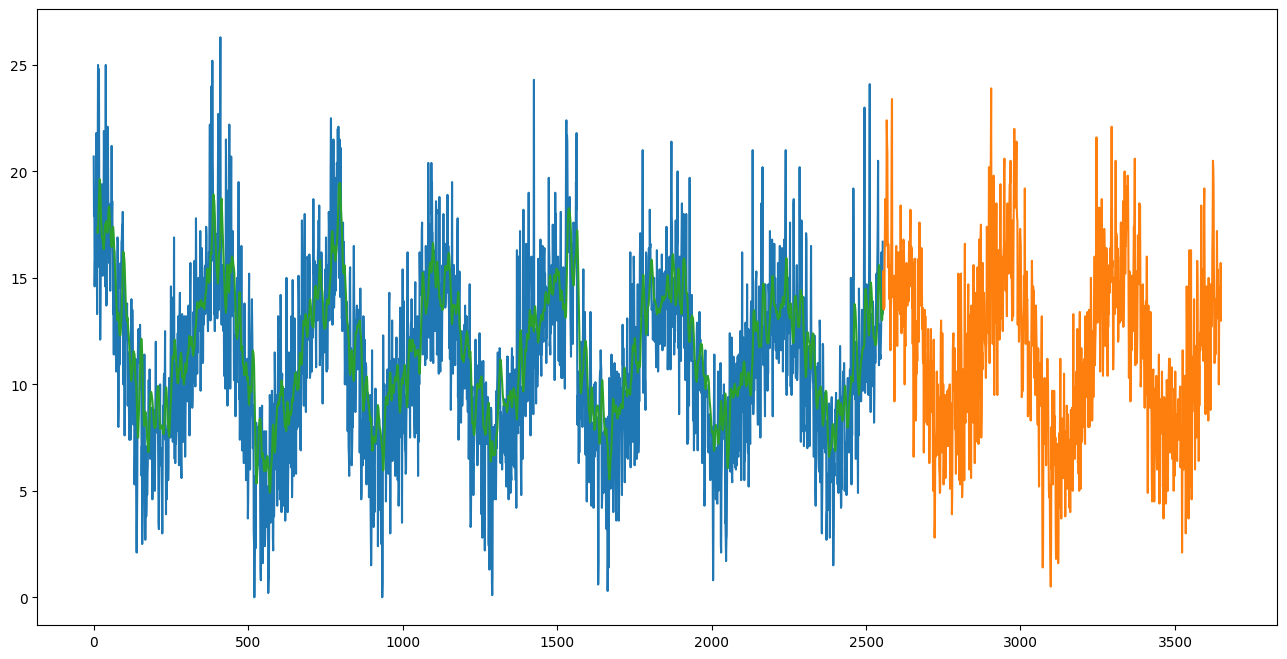

In [32]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(len(train_data)), scaler.inverse_transform(train_data), label='Training Data')
plt.plot(np.arange(len(train_data), len(dataset)), scaler.inverse_transform(test_data), label='Testing Data')
plt.plot(np.arange(look_back, len(train_predict)+look_back), train_predict, label='Training Predictions')
plt.plot(np.arange(len(train_predict)+look_back, len(dataset)), test_predict, label='Testing Predictions')
plt.legend()
plt.show()